In [1]:
import os
import scanpy as sc
from os.path import join

from spamosaic.framework import SpaMosaic

In [2]:
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # for CuBLAS operation and you have CUDA >= 10.2
import spamosaic.utils as utls
from spamosaic.preprocessing import RNA_preprocess, ADT_preprocess, Epigenome_preprocess

In [3]:
data_dir = './data/Simulations/dataset1/replicate1'

ad1_rna = sc.read_h5ad(join(data_dir, 's1_adata_rna.h5ad'))
ad1_adt = sc.read_h5ad(join(data_dir, 's1_adata_adt.h5ad'))
ad2_rna = sc.read_h5ad(join(data_dir, 's2_adata_rna.h5ad'))
ad3_adt = sc.read_h5ad(join(data_dir, 's3_adata_adt.h5ad'))

In [4]:
ad1_rna.obs['src'] = ad1_adt.obs['src'] = ['mult'] * ad1_rna.n_obs
ad2_rna.obs['src'] = ['rna'] * ad2_rna.n_obs
ad3_adt.obs['src'] = ['adt'] * ad3_adt.n_obs

for ad in [ad1_rna, ad1_adt, ad2_rna, ad3_adt]:
    ad.X = ad.layers['counts'].copy()

### preprocessing

In [5]:
input_dict = {
    'rna': [ad1_rna, ad2_rna, None],
    'adt': [ad1_adt, None,    ad3_adt]
}

input_key = 'X_pca_be'

In [6]:
RNA_preprocess(input_dict['rna'], batch_corr=True, favor='scanpy', n_hvg=None, lognorm=False, scale=True, batch_key='src', key=input_key)
ADT_preprocess(input_dict['adt'], batch_corr=True, favor='scanpy', lognorm=False, scale=True, batch_key='src', key=input_key)

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).
Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
Reach convergence after 9 iteration(s).


### training

In [7]:
model = SpaMosaic(
    modBatch_dict=input_dict, input_key=input_key,
    batch_key='src', 
    intra_knns=10, inter_knn_base=10, 
    w_g=0.8,
    seed=1234, 
    device='cuda:0'
)

model.train(net='wlgcn', lr=0.01, T=0.1, n_epochs=100)

batch0: ['rna', 'adt']
batch1: ['rna']
batch2: ['adt']
------Calculating spatial graph...
The graph contains 12960 edges, 1296 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 12960 edges, 1296 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 12960 edges, 1296 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 12960 edges, 1296 cells.
10.0000 neighbors per cell on average.
Searching MNN within rna
Finding MNN between (mult, rna) using KNN (10, 10)
Number of mnn pairs for rna:4342
Searching MNN within adt
Finding MNN between (mult, adt) using KNN (10, 10)
Number of mnn pairs for adt:5300


100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.77it/s]


In [8]:
ad_embs = model.infer_emb(input_dict, emb_key='emb', final_latent_key='merged_emb')
ad_mosaic = sc.concat(ad_embs)
ad_mosaic = utls.get_umap(ad_mosaic, use_reps=['merged_emb'])

/home/yanxh/anaconda3/envs/spamosaic-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


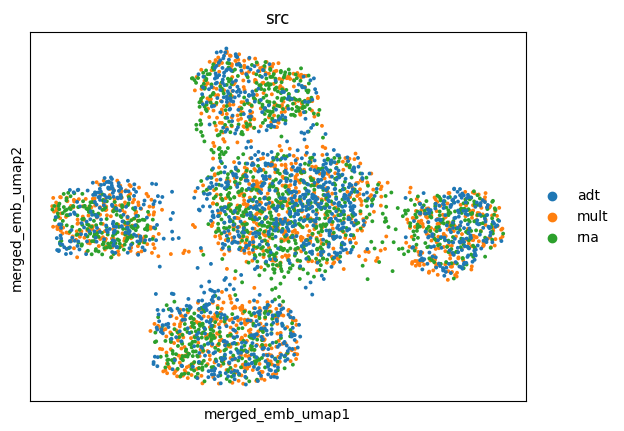

In [9]:
utls.plot_basis(ad_mosaic, basis='merged_emb_umap', color=['src'])

### clustering

In [10]:
utls.clustering(ad_mosaic, n_cluster=5, used_obsm='merged_emb', algo='kmeans', key='kmeans')
utls.split_adata_ob(ad_embs, ad_mosaic, 'obs', 'kmeans')

/home/yanxh/anaconda3/envs/spamosaic-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


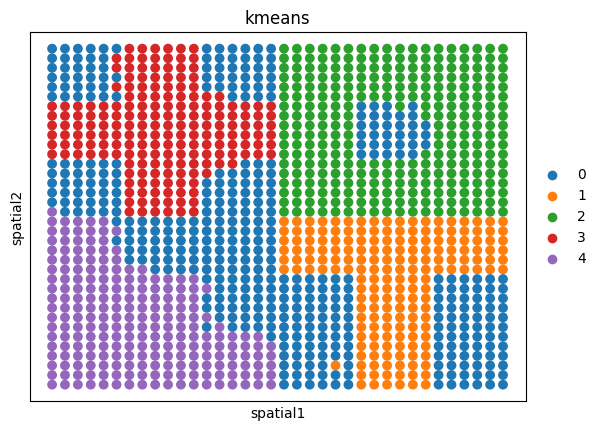

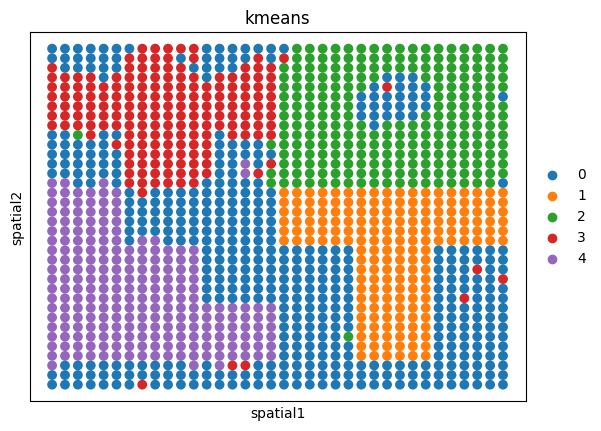

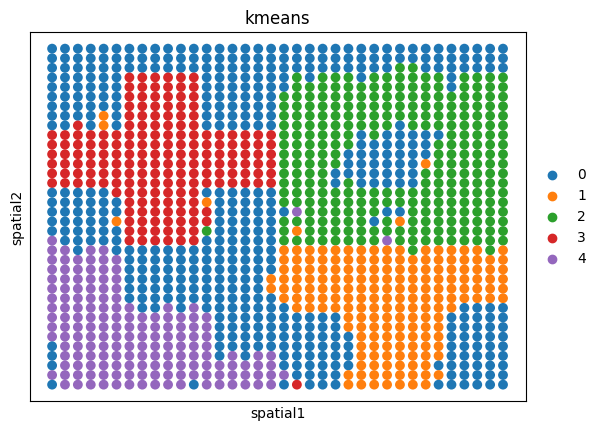

In [11]:
for ad in ad_embs:
    utls.plot_basis(ad, 'spatial', 'kmeans', s=200)